In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer
import nltk
from torch.utils.data import Dataset, DataLoader
from collections import Counter


In [3]:
import pandas as pd

df = pd.read_csv("hf://datasets/noob123/imdb_review_3000/imdb_review.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Ensure labels are numeric (0 for negative, 1 for positive)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})  # Adjust based on your actual label values

# Verify label distribution
print("sentiment distribution:")
print(df['sentiment'].value_counts())

texts = df['review'].values
labels = df['sentiment'].values.astype(np.int64)

sentiment distribution:
sentiment
1    1508
0    1491
Name: count, dtype: int64


In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2999 non-null   object
 1   sentiment  2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


In [9]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the texts
def tokenize_texts(text_list, max_length=128):
    return tokenizer(
        text_list.tolist(),
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )

train_encodings = tokenize_texts(X_train)
test_encodings = tokenize_texts(X_test)


In [10]:
# Create PyTorch Dataset
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx]
        }
        item['sentiment'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = IMDBDataset(train_encodings, y_train)
test_dataset = IMDBDataset(test_encodings, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Define the RNN model
class SimpleRNN(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask=None):
        # input_ids shape: (batch_size, seq_length)
        embedded = self.embedding(input_ids)
        # embedded shape: (batch_size, seq_length, embedding_dim)
        
        # RNN returns output and hidden state
        output, hidden = self.rnn(embedded)
        # output shape: (batch_size, seq_length, hidden_dim)
        # hidden shape: (n_layers, batch_size, hidden_dim)
        
        # We use the final hidden state for classification
        hidden = hidden[-1]  # Take the last layer's hidden state
        # hidden shape: (batch_size, hidden_dim)
        
        return self.fc(hidden)

# Model parameters
vocab_size = tokenizer.vocab_size
embedding_dim = 100
hidden_dim = 128
output_dim = 1  # Binary classification
n_layers = 1

# Initialize model
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)


In [12]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss


In [13]:
# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for batch in iterator:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['sentiment'].float().to(device)
        
        predictions = model(input_ids, attention_mask).squeeze(1)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [28]:
# Evaluation function
def evaluate_with_predictions(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['sentiment'].float().to(device)
            
            predictions = model(input_ids,attention_mask).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()

            # Convert predictions to binary (0 or 1)
            probs = torch.sigmoid(predictions)
            preds = torch.round(probs)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(iterator), accuracy, all_labels, all_preds, all_probs

# Run evaluation
test_loss, test_acc, y_true, y_pred, y_probs = evaluate_with_predictions(model, test_loader, criterion)


In [ ]:
"""
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().to(device)
            
            predictions = model(input_ids, attention_mask).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions to binary (0 or 1)
            preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(iterator), accuracy
    """

In [29]:
# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    
    # Only unpack the first two values (loss and accuracy) during training
    valid_loss, valid_acc, _, _, _ = evaluate_with_predictions(model, test_loader, criterion)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

# Final evaluation - here you can get all values if needed
test_loss, test_acc, y_true, y_pred, y_probs = evaluate_with_predictions(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.073
	 Val. Loss: 2.358
	 Val. Acc: 55.17%
Epoch: 02
	Train Loss: 0.072
	 Val. Loss: 2.415
	 Val. Acc: 54.83%
Epoch: 03
	Train Loss: 0.072
	 Val. Loss: 2.391
	 Val. Acc: 51.67%
Epoch: 04
	Train Loss: 0.074
	 Val. Loss: 2.416
	 Val. Acc: 51.67%
Epoch: 05
	Train Loss: 0.072
	 Val. Loss: 2.459
	 Val. Acc: 55.67%
Epoch: 06
	Train Loss: 0.070
	 Val. Loss: 2.499
	 Val. Acc: 55.00%
Epoch: 07
	Train Loss: 0.514
	 Val. Loss: 1.296
	 Val. Acc: 49.00%
Epoch: 08
	Train Loss: 0.464
	 Val. Loss: 1.071
	 Val. Acc: 54.00%
Epoch: 09
	Train Loss: 0.329
	 Val. Loss: 1.154
	 Val. Acc: 53.67%
Epoch: 10
	Train Loss: 0.264
	 Val. Loss: 1.246
	 Val. Acc: 54.67%
Test Loss: 1.246 | Test Acc: 54.67%


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


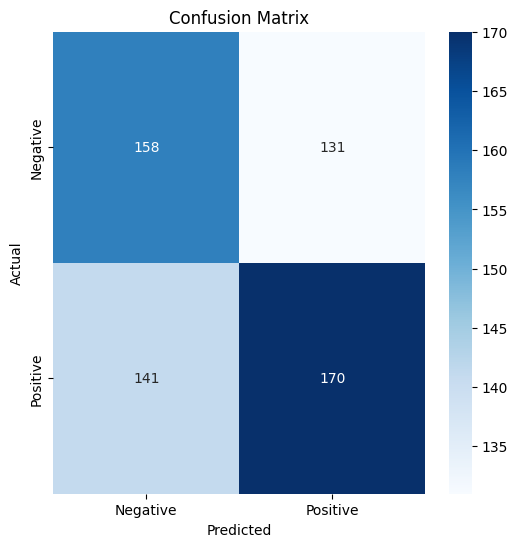

In [31]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred)

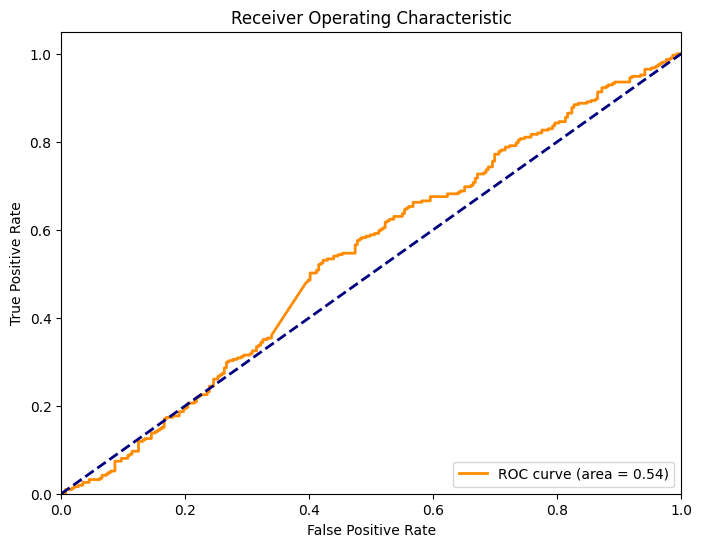

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.55      0.54       289
    Positive       0.56      0.55      0.56       311

    accuracy                           0.55       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.55      0.55      0.55       600



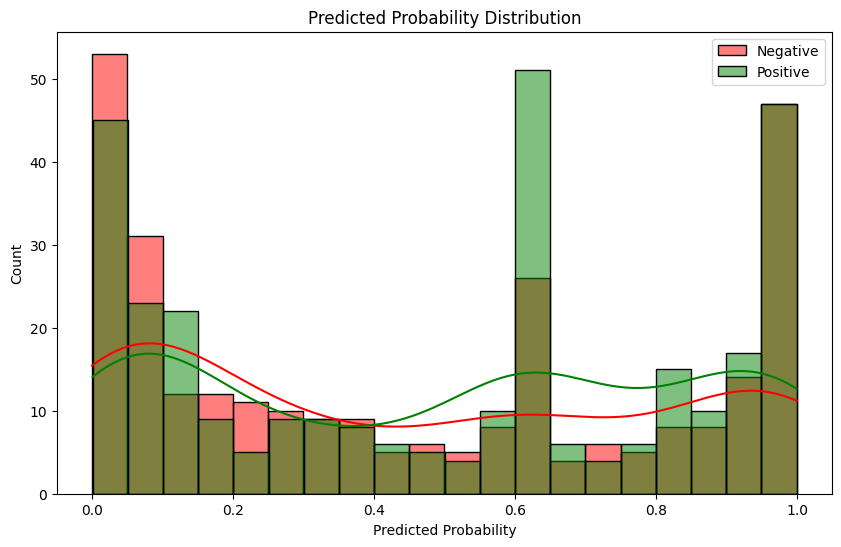

In [34]:
#  Probability Distribution (Bonus)
plt.figure(figsize=(10,6))
sns.histplot([y_probs[i] for i in range(len(y_probs)) if y_true[i] == 0], 
             color='red', label='Negative', kde=True, bins=20)
sns.histplot([y_probs[i] for i in range(len(y_probs)) if y_true[i] == 1], 
             color='green', label='Positive', kde=True, bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution')
plt.legend()
plt.show()